In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns 
import os

import matplotlib.pyplot as plt
from neuromaps.images import relabel_gifti, load_data, load_gifti, annot_to_gifti
from neuromaps import parcellate
from neuromaps import transforms 
from neuromaps.stats import compare_images
from neuromaps.nulls import hungarian
from neuromaps.parcellate import Parcellater
from scipy.stats import pearsonr

from matplotlib.cm import get_cmap
from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
base_path = os.path.dirname(os.getcwd())

# load enigma & turku partial correlation data 
turku_data = pd.read_csv(os.path.join(base_path,'data', 'turku_partial_r.csv'))
turku_data = turku_data.rename(columns={'region_sample': 'region', 'partial_r_sample': 'partial_r'})

enigma_data = pd.read_csv(os.path.join(base_path,'data','ENIGMA_S32_partial_correlation_between_cortical_thickness_and_chlorpromazine_equivalents.csv'))
enigma_data = enigma_data[:-2]
enigma_data['region'] = turku_data['region']


In [3]:
turku_data

,region,partial_r
0,lh_bankssts,-0.141103
1,lh_caudalanteriorcingulate,0.006816
2,lh_caudalmiddlefrontal,-0.342748
3,lh_cuneus,-0.055788
4,lh_entorhinal,0.039894
...,...,...
63,rh_supramarginal,-0.284110
64,rh_frontalpole,-0.188452
65,rh_temporalpole,-0.141326
66,rh_transversetemporal,-0.172825


In [198]:
def get_labels(annot):
    aparc = os.path.join(os.environ['SUBJECTS_DIR'], 'fsaverage', 'label', annot)
    labels, ctab , names = nib.freesurfer.read_annot(aparc)
    labels = [i-1 if i>3 else i for i in labels] # good lord
    return(labels)

lh_labels = get_labels('lh.aparc.annot')    
rh_labels = get_labels('rh.aparc.annot')    

def assign_values(data, hemi, labels):
    data = data[data['region'].str.contains(hemi)]
    data.index = range(1, len(data) + 1)
    partial_r_dict = data['partial_r'].to_dict()
    partial_r_dict.update([(0,0), (-1,0)])
    map = np.array([partial_r_dict.get(index) for index in labels])
    return(map)
    
lh_turku_map = assign_values(turku_data, 'lh', lh_labels )
rh_turku_map = assign_values(turku_data, 'rh', rh_labels )
turku_map = {'left': lh_turku_map, 'right': rh_turku_map}

lh_enigma_map = assign_values(enigma_data, 'lh', lh_labels )
rh_enigma_map = assign_values(enigma_data, 'rh', rh_labels )
enigma_map = {'left': lh_enigma_map, 'right': rh_enigma_map}

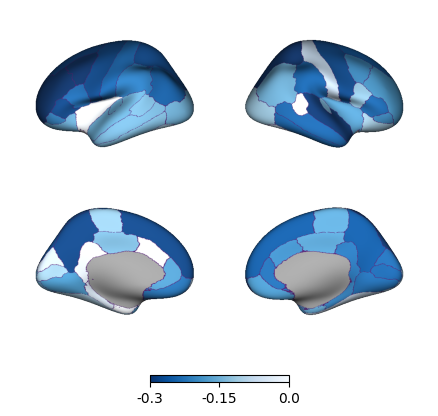

In [207]:
surface = fetch_fsaverage(density='164k')
lh, rh = surface['inflated']
dk = {'left': np.array(lh_labels), 'right': np.array(rh_labels)}

# plot
p = Plot(lh, rh, views=['lateral','medial'], zoom=1.2)
p.add_layer(turku_map, cmap='Blues_r',color_range=(-.3,0), cbar=True,zero_transparent=True  )
p.add_layer(dk, as_outline=True, cbar=False)
pic = p.build()
pic.savefig(os.path.join(base_path, 'figures', 'fig3_turku_dk_ap.jpg'), dpi=300, transparent=True)

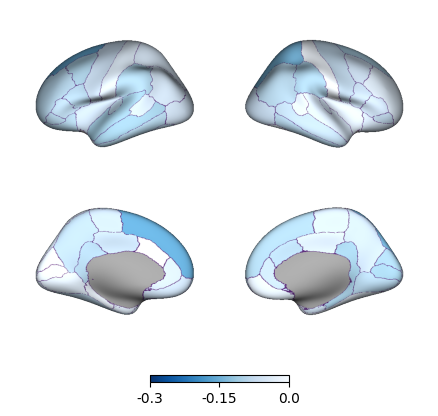

In [208]:
# plot
p = Plot(lh, rh, views=['lateral','medial'], zoom=1.2)
p.add_layer(enigma_map, cmap='Blues_r',color_range=(-.3,0), cbar=True,zero_transparent=True  )
p.add_layer(dk, as_outline=True, cbar=False)
pic = p.build()
pic.savefig(os.path.join(base_path, 'figures', 'fig3_enigma_dk_ap.jpg'), dpi=300, transparent=True)

In [203]:
# do enigma map and turku map correlate?
turku_r = turku_data['partial_r'].to_numpy()
enigma_r = enigma_data['partial_r'].to_numpy()
rho, p = pearsonr(enigma_r, turku_r)

dk_fsaverage_164k = (os.path.join(base_path, 'parcellations', 'atlas-desikankilliany_space-fsaverage_den-164k_hemi-L.aparc-1.annot'),
                     os.path.join(base_path, 'parcellations', 'atlas-desikankilliany_space-fsaverage_den-164k_hemi-R.aparc-1.annot'))

dk_fsaverage_164k = annot_to_gifti(dk_fsaverage_164k)  # this does relabel_gift and also converts the annot file to gifti


# get spins 
spins = pd.read_csv(os.path.join(base_path, 'parcellations','spins_hungarian_aparc+aseg_ctx.csv'), header=None)
nspins = spins.values.shape[1]

# get 10k rotations 
rotated = hungarian(data=turku_r, n_perm=10000, spins=spins, parcellation=dk_fsaverage_164k) 
    
# get null
n = np.zeros((nspins, ))
for i in range(nspins):
    n[i] = pearsonr(enigma_r, rotated[:,i])[0]    

# get p-value
pspin = (1 + sum(abs(n) > abs(rho ))) / (nspins + 1)

print(rho, pspin)

0.4741129502749724 0.0007999200079992001


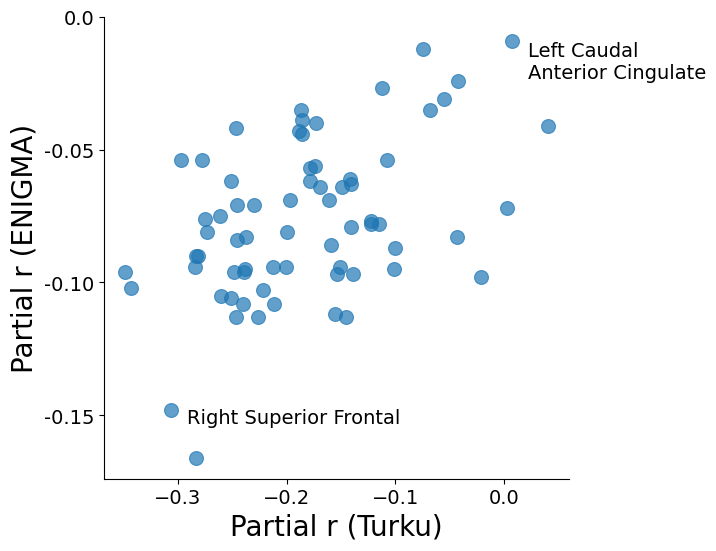

In [204]:
# plot correlations 
fig  = plt.figure(figsize=(6,6))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

sns.scatterplot(x=turku_r, y=enigma_r, edgecolor=None, alpha=0.7, s=100)


fontdict = {'size':20}
plt.xlabel("Partial r (Turku)", fontdict=fontdict)
plt.ylabel("Partial r (ENIGMA)", fontdict=fontdict)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks(ticks=[0, -0.05, -0.10,  -0.15 ], labels=["0.0",  "-0.05","-0.10",  "-0.15" ])
plt.text(turku_data['partial_r'][1] +0.015, enigma_data['partial_r'][1]-0.014, 'Left Caudal \nAnterior Cingulate', size=14)
plt.text(turku_data['partial_r'][60]+0.015, enigma_data['partial_r'][60]-0.005, 'Right Superior Frontal', size=14)

plt.savefig(os.path.join(base_path, 'figures' ,'fig3_correlation_TURKU_ENIGMA.jpg'), dpi=300, bbox_inches="tight" )
plt.show()